In [37]:
#!/usr/bin/env python3.7.6

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import rasterio
from scipy.interpolate import griddata

# import geopandas as gpd

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib import pyplot as p

import cmocean # Beautiful colormaps for oceanography
import cmocean.cm as cmo
import os
import matplotlib.patheffects as path_effects

from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from netCDF4 import Dataset as NetCDFFile 

from obspy.imaging.beachball import beach

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from matplotlib.patches import Polygon

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

import shapefile as shp

from shapely.geometry import LineString

# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [38]:
data_jpn = pd.read_csv("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/ryu_kur_class_by_loc_net.csv", header = 'infer')
data = pd.read_csv("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/sam_class_by_loc.csv", header = 'infer')

In [39]:
data.columns = data_jpn.columns
# combine two datasets
# data = pd.concat([data_ryu_kur, data_mariana], ignore_index=True)

In [40]:
# data.dtypes

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [41]:
data.columns

Index(['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENTID', 'DEPFIX', 'DEPQUAL',
       'EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP', 'MPR',
       'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2', 'T_VAL',
       'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL', 'N_AZM',
       'SLAB_DIP', 'CLASS', 'YEARS'],
      dtype='object')

In [42]:
import geopandas as gpd

# plate boundary data
shp_file = "/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/PB2002_boundaries.shx"
# sf = shp.Reader(shp_file)
gdf = gpd.read_file(shp_file)
gdf.head()

,LAYER,Name,Source,PlateA,PlateB,Type,geometry
0,plate boundary,AF-AN,Mueller et al. [1987],AF,AN,None,"LINESTRING (-0.43790 -54.85180, -0.03883 -54.6..."
1,plate boundary,AF-AN,"by Peter Bird, October 2001",AF,AN,None,"LINESTRING (7.77235 -54.39600, 8.28834 -54.032..."
2,plate boundary,AN-AF,Lemaux et al. [2002],AN,AF,None,"LINESTRING (32.12580 -46.99980, 31.86540 -47.2..."
3,plate boundary,SO-AN,Lemaux et al. [2002],SO,AN,None,"LINESTRING (32.12580 -46.99980, 33.17390 -47.2..."
4,plate boundary,SO-AN,Mueller et al. [1987],SO,AN,None,"LINESTRING (38.08270 -44.61880, 38.19370 -44.4..."


In [43]:
data_dw_mthrust = data[(data['CLASS'] != 'UPPER')]

mag = 7
data_Mbig = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] >= mag)]
data_Dbig = data[(data['CLASS'] == 'DGOING') & (data['MW'] >= mag) & (data['DEPTH'] > 70)]

In [44]:
# rupture outline
rup_2015 = pd.read_csv("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/sam_rup/sam_sqk_02_rup.csv",
                      skiprows=1)

rup_2010 = pd.read_csv("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/rijsingen_eq/scraped/sam_rup/sam_sqk_05_rup.csv",
                      skiprows=1)

In [45]:
# topography

# Define the GeoTIFF file path
topo = "/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/etopo-s-america.tiff"

# Open the GeoTIFF file using rasterio
with rasterio.open(topo) as src:
    # Read the topography data and extract the extent
    topography_data = src.read(1)  # Read the first band (adjust as needed)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

In [46]:
import xarray as xr

## plate age

plate_age = xr.open_dataset("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/South-america_age.grd")

lon = plate_age.variables['lon'][:]
lat = plate_age.variables['lat'][:]
age = plate_age.variables['z'][:]

In [47]:
## s - america slab

slab_kk = NetCDFFile("/Users/zuhair/OneDrive - Nanyang Technological University/Research/PhD_Monash/Paper2/time-series/data/sam_slab2_dep_02.23.18.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab_kk = slab_kk.variables['x'][:]
lat_slab_kk = slab_kk.variables['y'][:]
depth_slab_kk = slab_kk.variables['z'][:]
depth_slab_kk = depth_slab_kk*-1

# creating meshgrid from our list of spatial coordinates
lon_slab_kk, lat_slab_kk = np.meshgrid(lon_slab_kk, lat_slab_kk)

## Map

In [48]:
mag = 9
data_dw = data[(data['CLASS'] == 'DGOING')
               & (data['DEPTH'] > 70) & (data['MW'] <= mag)]
data_mthrust = data[(data['CLASS'] == 'MTHRUST') & (data['DEPTH'] < 50) &
                    (data['MW'] <= mag)]


dpi = 200
fig, ax = plt.subplots(dpi = dpi, figsize=(5,5))

fig1 = ax

projection = cartopy.crs.PlateCarree()
fig1 = plt.axes(projection = projection)

fig1.set_extent([-85, -60, -45, 5])

# Plot the topography data

vmin, vmax = -8000, 3000
fig1.imshow(topography_data, extent=extent, origin='upper',
            alpha = 1, cmap='Greys_r',
            vmin=vmin, vmax=vmax,
            transform=cartopy.crs.PlateCarree()) # terrain


# Create a contour plot of the plate age data
contour_levels = range(20, 61, 1)
contour = fig1.contourf(lon, lat, age, cmap='rainbow_r',
                        levels=contour_levels,
                        vmin = 20, vmax = 60, alpha=0.5)
# Add a colorbar
cbaxes = inset_axes(fig1, width="30%", height="2%", loc=2,
                   bbox_to_anchor=(0.6,-0.12,1,1), bbox_transform=fig1.transAxes) 
cbar = plt.colorbar(contour, ax=fig1, ticks=[20, 40, 60], orientation='horizontal', cax=cbaxes)
size=7
cbar.set_label(label='Age (Myr)', size=size, weight='bold')
cbar.ax.tick_params(labelsize=size)
# cbar.ax.yaxis.set_ticks_position('left')
# cbar.ax.yaxis.set_label_position('left')

## plot slab contours
depth_levels=[0, 50, 100, 200, 300, 400, 500, 600, 700]

color = 'k'
contour_kk = fig1.contour(lon_slab_kk, lat_slab_kk, depth_slab_kk, levels=depth_levels,
                       colors=color, linestyles='dashed', linewidths=0.5, transform=cartopy.crs.PlateCarree())
fig1.clabel(contour_kk, inline=True, fmt='%d', fontsize=5, colors=color, rightside_up=True)



# Add coastlines without filled colors
fig1.add_feature(NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='grey', linewidth = 0.2, facecolor='none'  # Set facecolor to 'none'
))
    

###########


alpha = 0.7
size = 10
fig1.scatter(data_mthrust['LON'], data_mthrust['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='red', linewidths = 0.3, alpha=1, label='Megathrust events')

fig1.scatter(data_dw['LON'], data_dw['LAT'], s=size, marker='o',
                 facecolor='none', edgecolor='blue', linewidths = 0.2, alpha=1, label='Slab events (> 70 km)')


data_great = data[(data['MW'] == data['MW'].max())]

fig1.scatter(data_great['LON'], data_great['LAT'],
            marker = '*', s = 100, c = 'g', alpha = 1,
             edgecolor = 'k', linewidths = 0.4, label = '2010 $M_w$ 8.8 Maule') #label = '$M_w$ ≥ 8.8 Maule'

# fig1.scatter(data_Dbig['LON'], data_Dbig['LAT'],
#             marker = '*', s = 50, c = 'yellow', alpha = 1,
#              edgecolor = 'blue', linewidths = 0.4, label = '$M_w$ ≥ 6.0 slab')


# fig1.plot(rup_2010['LON'], rup_2010['LAT'], '-', c = 'red', linewidth = 1.5, alpha=1)
# fig1.plot(rup_2015['LON'], rup_2015['LAT'], '-', c = 'yellow', linewidth = 1.5, alpha=1)

# fig1.axhline(y=34, color='k', linestyle='--', lw=0.5, label='Latitude -6°')

fontsize = 6
fig1.legend(loc = 'upper right',
            fontsize = fontsize,
            facecolor="white",
            edgecolor="black",
            markerscale=1)

# Manage latitude and longitude ticks
# Set the desired tick locations and labels
lat_ticks = [-45, -35, -25, -15, -5, 5]
lon_ticks = [-85, -80, -75, -70, -65, -60]
fig1.set_xticks(lon_ticks)
fig1.set_yticks(lat_ticks)


fig1.axhline(y=-44, color='k', linestyle='--', lw=0.5)
fig1.axhline(y=-26, color='k', linestyle='--', lw=0.5)
fig1.axhline(y=-14, color='k', linestyle='--', lw=0.5)

fs = 15
fig1.text(-80, -6, 'A', ha='center', fontsize=fs)
fig1.text(-80, -20, 'B', ha='center', fontsize=fs)
fig1.text(-80, -35, 'C', ha='center', fontsize=fs)

# gdf = gdf[(gdf['Name'] == 'SO-AN')]
# gdf.plot(ax=fig1, color='k', linewidth=0.5)

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Map.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Map-1.png"
#             , dpi = 500, transparent= True, bbox_inches='tight')

Text(-80, -35, 'C')

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 3 Axes>

In [49]:
# mag = 5.1
# data_dw = data[(data['CLASS'] == 'DGOING')
#                & (data['DEPTH'] > 100) & (data['MW'] <= mag)]
# data_mthrust = data[(data['CLASS'] == 'MTHRUST') & (data['MW'] <= mag)]



# figsize=(7,3)
# fig, ax = plt.subplots(dpi = dpi, figsize=figsize)

# fig1 = ax

# fig1.scatter(data_dw['YEARS'], data_dw['LAT'],
#              marker = 'o', s = 20, facecolor = 'white',
#              edgecolor = 'blue', linewidths = 0.2, label = '> 70 km Slab events ($M_w$ ≤ 5.0)')

# fig1.scatter(data_mthrust['YEARS'], data_mthrust['LAT'],
#              marker = 'o', s = 10, facecolor = 'white',
#              edgecolor = 'red', linewidths = 0.3, label = 'Megathrust events ($M_w$ ≤ 5.0)')

# fig1.set_xlabel('Years from 2010 Maule EQ')
# # fig1.set_ylabel(r'$M_w$')
# fig1.set_ylabel(r'Latitude')

# data_great = data[(data['MW'] >= 8)]
# fig1.scatter(data_great['YEARS'], data_great['LAT'],
#             marker = '*', s = 100, c = 'yellow', alpha = 1,
#              edgecolor = 'k', linewidths = 0.4, label = '$M_w$ ≥ 8.0')

# # Draw a vertical line at the location of the largest magnitude year
# fig1.axvline(x=0, color='g', lw=1, linestyle='--', label = '$M_w$ 8.8 Maule')


# fs = 7
# fig1.legend(loc = 'upper left',
#             fontsize = fs,
#             facecolor="white",
#             framealpha=1,
#             edgecolor="black",
#             markerscale=1)

# # fig1.text(-20, 28, '$M_w$ ≤ 5.0 \n Depth > 0 km', ha='center', fontsize=fs)

# fig1.axhline(y=-44, color='k', linestyle='--', lw=0.5)
# fig1.axhline(y=-26, color='k', linestyle='--', lw=0.5)
# fig1.axhline(y=-14, color='k', linestyle='--', lw=0.5)

# fs = 12
# fig1.text(-15, -20, 'A', ha='center', fontsize=fs)
# fig1.text(-15, -32, 'B', ha='center', fontsize=fs)


# # fig1.set_ylim([-45, 5])

# # tick location
# lat_ticks = [-42, -32, -22, -12, -2, 8]
# # lon_ticks = [-85, -80, -75, -70, -65, -60]

# # fig1.set_xticks(lon_ticks)
# fig1.set_yticks(lat_ticks)

# # plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/Japan-Lat-Years.jpeg"
# #             , dpi = 500, transparent= True, bbox_inches='tight')

/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_23933/3816453121.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mthrust_C['DATE'] = pd.to_datetime(data_mthrust_C['DATE'])
/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_23933/3816453121.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_mthrust_C['YEARS'] = data_mthrust_C['DATE'].dt.year
/var/folders/7l/z17fky090gggg0_sw6p28lnr0000gp/T/ipykernel_23933/3816453121.py:40: SettingWithCopyWarning: 
A value is trying to be s

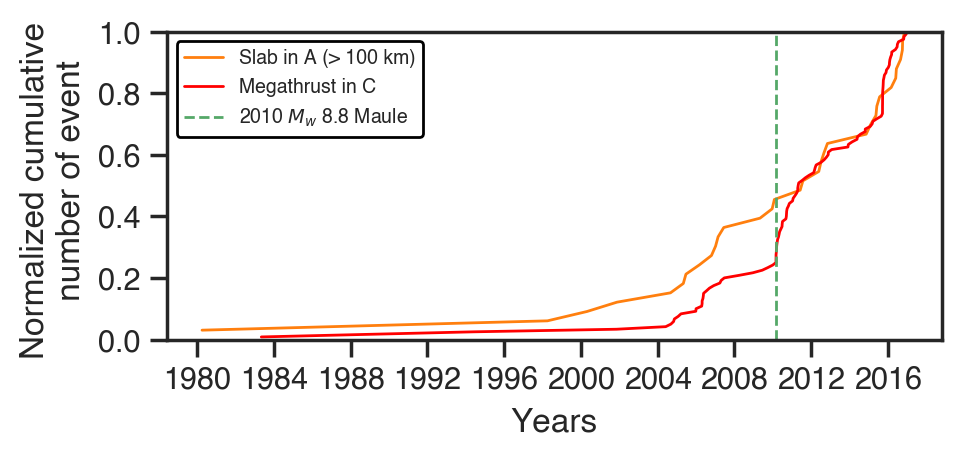

In [50]:
depth = 100
mag = 5.1

## for region A
lat_1 = 5
lat_2 = -14

## for region B
# lat_2 = -14
lat_3 = -26

## for region C
# lat_3 = -26
lat_4 = -44

# data = data[(data['YEARS'] > -10) & (data['YEARS'] < 0)]

data_DW_A = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_2) & (data['LAT'] <= lat_1) &
                    (data['MW'] <= mag) & (data['DEPTH'] > depth)]

data_DW_B = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_3) & (data['LAT'] < lat_2) &
                    (data['MW'] <= mag) & (data['DEPTH'] > depth)]

data_DW_C = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_4) & (data['LAT'] < lat_3) &
                    (data['MW'] <= mag) & (data['DEPTH'] > depth)]

data_mthrust_C = data[(data['CLASS'] == 'MTHRUST') &
                    (data['LAT'] >= lat_4) & (data['LAT'] < lat_3) &
                    (data['MW'] <= mag)]

# Convert the 'Date' column to datetime format
data_mthrust_C['DATE'] = pd.to_datetime(data_mthrust_C['DATE'])
# Extract the year from the 'Date' column
data_mthrust_C['YEARS'] = data_mthrust_C['DATE'].dt.year

# Convert the 'Date' column to datetime format
data_DW_A['DATE'] = pd.to_datetime(data_DW_A['DATE'])
# Extract the year from the 'Date' column
data_DW_A['YEARS'] = data_DW_A['DATE'].dt.year

# Convert the 'Date' column to datetime format
data_DW_B['DATE'] = pd.to_datetime(data_DW_B['DATE'])
# Extract the year from the 'Date' column
data_DW_B['YEARS'] = data_DW_B['DATE'].dt.year

# Convert the 'Date' column to datetime format
data_DW_C['DATE'] = pd.to_datetime(data_DW_C['DATE'])
# Extract the year from the 'Date' column
data_DW_C['YEARS'] = data_DW_C['DATE'].dt.year


# Sort the data by date
data_DW_A = data_DW_A.sort_values(by='DATE')
data_DW_B = data_DW_B.sort_values(by='DATE')
data_DW_C = data_DW_C.sort_values(by='DATE')
data_mthrust_C = data_mthrust_C.sort_values(by='DATE')


# Calculate cumulative earthquake counts
cumulative_counts_DW_A = range(1, len(data_DW_A) + 1)
cumulative_counts_DW_B = range(1, len(data_DW_B) + 1)
cumulative_counts_DW_C = range(1, len(data_DW_C) + 1)
cumulative_counts_mthrust_C = range(1, len(data_mthrust_C) + 1)

# Calculate the total number of earthquakes
total_earthquakes_DW_A = len(data_DW_A)
total_earthquakes_DW_B = len(data_DW_B)
total_earthquakes_DW_C = len(data_DW_C)
total_earthquakes_mthrust_C = len(data_mthrust_C)

# Normalize cumulative counts by dividing by the total number
normalized_counts_DW_A = [count / total_earthquakes_DW_A for count in cumulative_counts_DW_A]
normalized_counts_DW_B = [count / total_earthquakes_DW_B for count in cumulative_counts_DW_B]
normalized_counts_DW_C = [count / total_earthquakes_DW_C for count in cumulative_counts_DW_C]
normalized_counts_C = [count / total_earthquakes_mthrust_C for count in cumulative_counts_mthrust_C]

fig, ax = plt.subplots(dpi = dpi, figsize=(5,2))

fig1 = ax

# Plot the cumulative earthquake counts
fig1.plot(data_DW_A['DATE'], normalized_counts_DW_A, color='tab:orange', label = 'Slab in A (> 100 km)', lw=1)
# fig1.plot(data_DW_B['DATE'], normalized_counts_DW_B, color='tab:blue', label = 'Slab in B (> 100 km)', lw=1)
# fig1.plot(data_DW_C['DATE'], normalized_counts_DW_C, color='tab:pink', label = 'Slab in C (> 100 km)', lw=1)
fig1.plot(data_mthrust_C['DATE'], normalized_counts_C, color='red', label = 'Megathrust in C', lw=1)

fig1.set_xlabel('Years')
# # fig1.set_ylabel(r'$M_w$')
fig1.set_ylabel('Normalized cumulative \n number of event')

# # data = pd.read_csv(eq_file, header = 'infer')
largest_earthquake = data[data['MW'] == data.MW.max()]
## Convert the 'Date' column to datetime format
largest_earthquake['DATE'] = pd.to_datetime(largest_earthquake['DATE'])

# fig1.axvline(x=largest_earthquake['DATE'], color='k', lw=1, linestyle='--')
fig1.vlines(x=largest_earthquake['DATE'], ymin=0, ymax=1, color='g', linestyle='--', lw=1, label='2010 $M_w$ 8.8 Maule')

fs = 7
fig1.legend(loc = 'upper left',
            fontsize = fs,
            facecolor="white",
            framealpha=1,
            edgecolor="black",
            markerscale=1)

# fig1.set_xlim([1998, 2005])
fig1.set_ylim([0, 1])

plt.show()

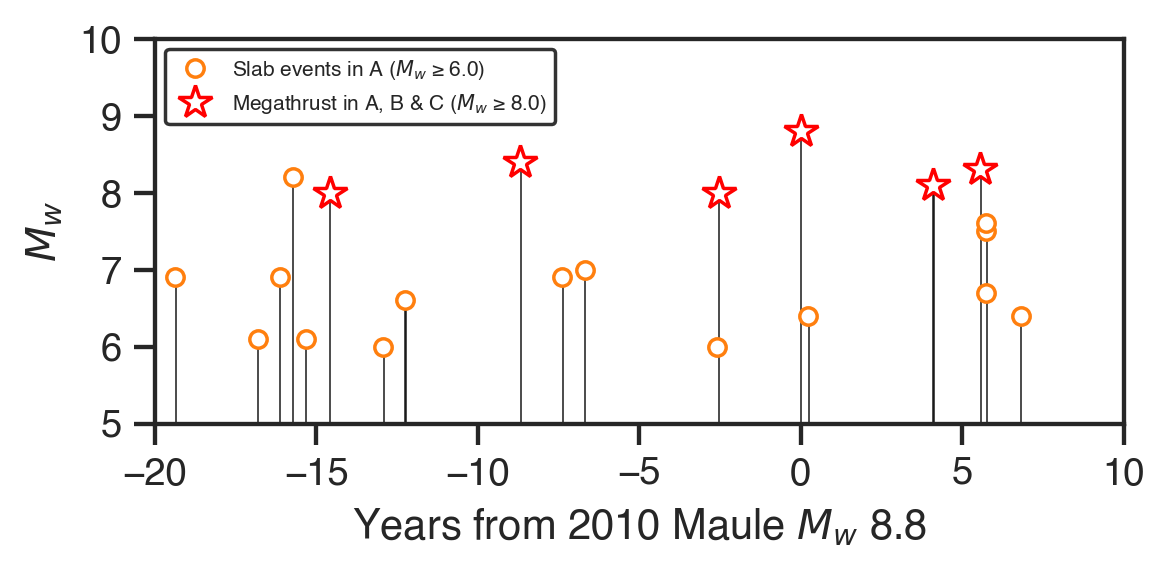

In [51]:
mag_dw = 6
dep_upper = 300
# dep_lower = 700

mag_mt = 8

## for region A
lat_1 = 5
lat_2 = -14

## for region B
# lat_2 = -14
lat_3 = -26

## for region C
# lat_3 = -26
lat_4 = -44


data_DW_A = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_2) & (data['LAT'] <= lat_1) &
                    (data['MW'] >= mag_dw) & (data['DEPTH'] > dep_upper)]

data_DW_B = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_3) & (data['LAT'] < lat_2) &
                    (data['MW'] >= mag_dw) & (data['DEPTH'] > dep_upper)]

data_DW_C = data[(data['CLASS'] == 'DGOING') &
                    (data['LAT'] >= lat_4) & (data['LAT'] < lat_3) &
                    (data['MW'] >= mag_dw) & (data['DEPTH'] > dep_upper)]

data_mthrust_ABC = data[(data['CLASS'] == 'MTHRUST') &
                    (data['LAT'] >= lat_4) & (data['LAT'] < lat_1) &
                    (data['MW'] >= mag_mt)]

figsize = (5,2)
dpi=250
width = 0.16

lw = 0.2
size = 5


fig, ax = plt.subplots(1, dpi=dpi, figsize = figsize, sharex= False)
fig1=ax


fig1.bar(data_DW_A['YEARS'], data_DW_A['MW'], color = 'k', width = width)
fig1.plot(data_DW_A['YEARS'], data_DW_A['MW'], 'o', color='tab:orange', lw=lw,
          markersize = size, markerfacecolor = 'white', label = 'Slab events in A ($M_w$ ≥ 6.0)')

# fig1.bar(data_DW_B['YEARS'], data_DW_B['MW'], color = 'k', width = width)
# fig1.plot(data_DW_B['YEARS'], data_DW_B['MW'], 'o', color='tab:blue', lw=lw,
#           markersize = size, markerfacecolor = 'white', label = 'Slab events in B ($M_w$ ≥ 6.0)')

# fig1.bar(data_DW_C['YEARS'], data_DW_C['MW'], color = 'k', width = width)
# fig1.plot(data_DW_C['YEARS'], data_DW_C['MW'], 'o', color='tab:pink', lw=lw,
#           markersize = size, markerfacecolor = 'white', label = 'Slab events in C ($M_w$ ≥ 6.0)')

fig1.bar(data_mthrust_ABC['YEARS'], data_mthrust_ABC['MW'], color = 'k', width = width)
fig1.plot(data_mthrust_ABC['YEARS'], data_mthrust_ABC['MW'], '*', color='red', lw=0.3,
          markersize = 10, markerfacecolor = 'white', label = 'Megathrust in A, B & C ($M_w$ ≥ 8.0)')

fig1.set_xlabel('Years from 2010 Maule $M_w$ 8.8')
#plt.ylabel(r'$\Sigma M_o$')
fig1.set_ylabel(r'$M_w$')

# fig1.set_xlim([-35, -32])
fig1.set_xlim([-20, 10])
fig1.set_ylim([5, 9.5])

# Draw a vertical line at the location of the largest magnitude year
# fig1.axvline(x=0, color='g', lw=1, linestyle='--', label = '$M_w$ 8.8 Maule event')


fontsize = 6
fig1.legend(loc = 'upper left',
            fontsize = fontsize,
            facecolor="white",
            edgecolor="black",
            markerscale=1)

# # tick location
y_ticks = [5, 6, 7, 8, 9, 10]
# # lon_ticks = [-85, -80, -75, -70, -65, -60]

# # fig1.set_xticks(lon_ticks)
fig1.set_yticks(y_ticks)

# plt.savefig("/Users/mohd0001/Research/PhD_Monash/Paper2/output/hist/TimeSeries_JKK_mega-Ryu_Slab.jpeg"
#             , dpi = 500, transparent= True, bbox_inches='tight')

In [52]:
year = 2010 # Replace with your specific year
month = 2    # Replace with your specific month

# Convert the year and month to a decimal year
decimal_year = year + (month - 1) / 12

print(decimal_year)

2010.0833333333333


In [53]:
# data_mthrust.MW

TypeError: kdeplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

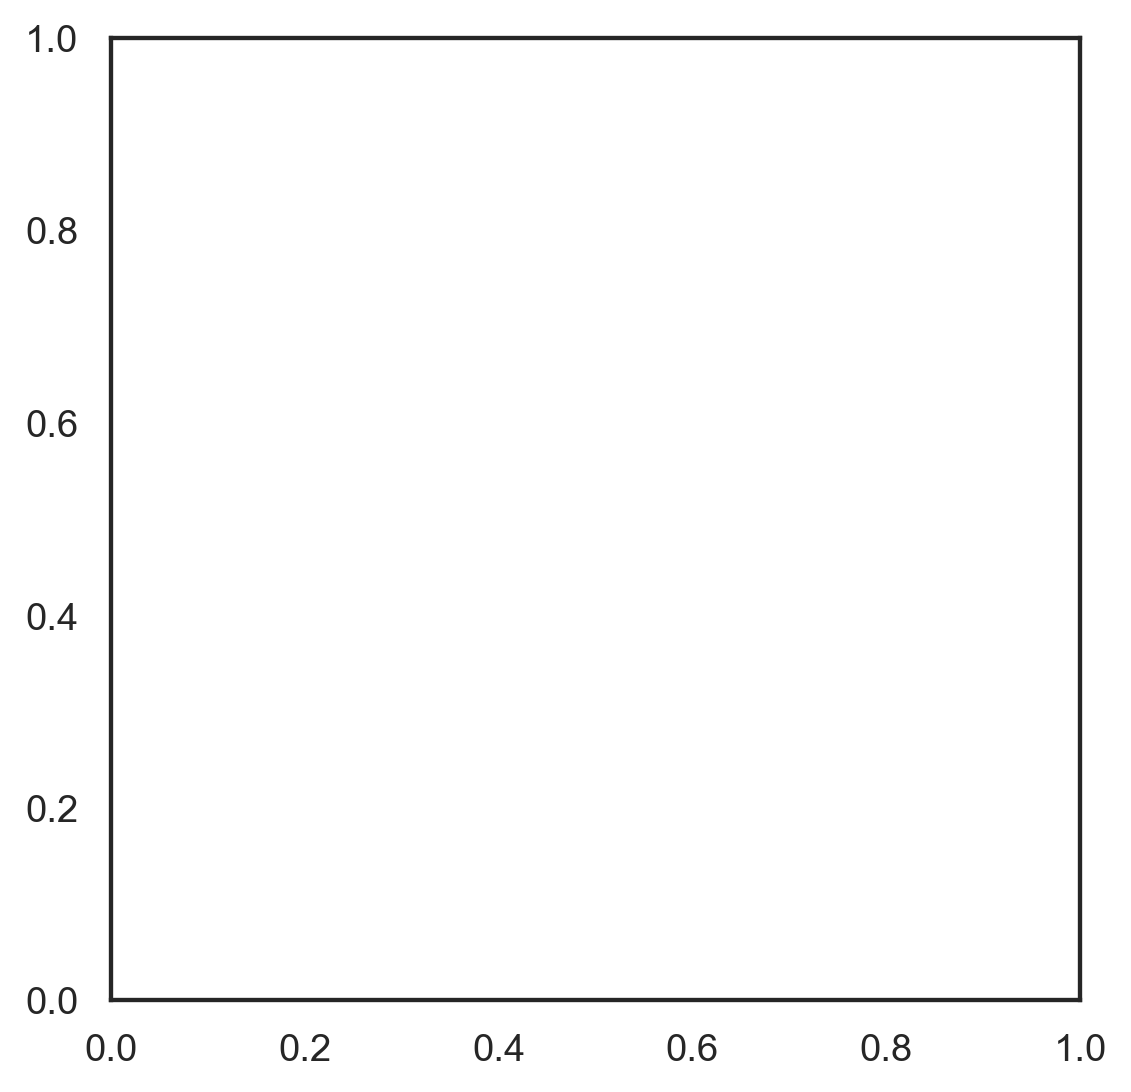

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

# Load earthquake data from a CSV file
earthquake_data = data[(data['CLASS'] == 'DGOING') &
                      (data['YEARS'] > 0) &  (data['YEARS'] < 2) & (data['MW'] > 4)
                      & (data['DEPTH'] > 100)]

# Extract latitude and longitude columns from the DataFrame
latitude = earthquake_data['LAT']
longitude = earthquake_data['LON']

# Define the grid for the KDE heatmap
x = longitude.values
y = latitude.values

# Specify the bandwidth for the kernel density estimation (adjust as needed)
bandwidth = 0.1  # You may need to fine-tune this value

# Create a KDE model
kde = KernelDensity(bandwidth=bandwidth)

# Fit the model to the data
kde.fit(list(zip(x, y)))

# Create a grid of points for the heatmap
xv, yv = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),  # Adjust the number of points as needed
    np.linspace(y.min(), y.max(), 100)
)

# Evaluate the KDE model on the grid
grid_points = np.vstack([xv.ravel(), yv.ravel()]).T
kde_values = kde.score_samples(grid_points)

# Reshape the KDE values to match the grid shape
kde_values = kde_values.reshape(xv.shape)

# Create a heatmap using seaborn
sns.set(style="white")
fig, ax = plt.subplots(1, dpi=dpi, figsize = (5, 5))
fig1 = ax
# plt.figure(figsize=(10, 8))
sns.kdeplot(x, y, cmap="rainbow", cbar=True, n_levels=50, shade=True)

# Add earthquake data points as scatter points (optional)
fig1.scatter(longitude, latitude, color='yellow', marker='o', s=2, label='Earthquake Events')


# ## plot slab contours
# depth_levels=[0, 100, 200, 300, 400, 500, 600, 700]

# color = 'k'
# contour_kk = fig1.contour(lon_slab_kk, lat_slab_kk, depth_slab_kk, levels=depth_levels,
#                        colors=color, linestyles='dashed', linewidths=0.5)
# fig1.clabel(contour_kk, inline=True, fmt='%d', fontsize=5, colors=color, rightside_up=True)


# # Customize the plot
# plt.title('Kernel Density Estimation Heatmap of Earthquake Events')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
fig1.legend(loc = 'upper left',
            fontsize = 7,
            facecolor="white",
            framealpha=1,
            edgecolor="grey",
            markerscale=1)

fig1.set_xlim([-85, -60])
fig1.set_ylim([-45, 5])

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load earthquake data from a CSV file
# earthquake_data = pd.read_csv('earthquake_catalog.csv')

# Check for NaN and infinite values in the 'Magnitude' column
invalid_values = earthquake_data[earthquake_data['MW'].isna() | np.isinf(earthquake_data['MW'])]

# Display the rows with problematic values
print("Rows with problematic values:")
print(invalid_values)

# Remove NaN and infinite values from the 'Magnitude' column
earthquake_data = earthquake_data[~earthquake_data['MW'].isna() & ~np.isinf(earthquake_data['MW'])]

# Extract the magnitudes from the earthquake data
magnitudes = earthquake_data['MW']

# Continue with the rest of the code for analysis
# ...

# If the issue persists, review the 'Magnitude' column in your CSV file and the data cleaning steps.
